# Entrenamiento con dataset simulado y test con Ml100k

In [93]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt 

ROOT = Path.cwd().resolve()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / 'src').exists():
    
    sys.path.insert(0, str(ROOT.parent))

In [94]:
from src.data.loading import load_movielens_100k, build_ratings_matrix

from surprise import Dataset, Reader, SVDpp, SVD, BaselineOnly, KNNBasic

from surprise.model_selection import train_test_split,cross_validate

from cluster_simulation import generate_mask_zipf_global, fill_ratings_clusters


Cargar los datos de ML como test

In [95]:
ratings_df, users_df, movies_df = load_movielens_100k()
reader = Reader(rating_scale=(1, 5))
data_test = Dataset.load_from_df(ratings_df[['UserID', 'MovieID', 'Rating']], reader)
ratings_matrix = build_ratings_matrix(ratings_df)
ratings_matrix.shape


(943, 1682)

Cargar datos simulación como train

In [96]:
U, I = 943, 1682
pairs, uc, ic, A = generate_mask_zipf_global(
    U,
    I,
    density=0.063,
    alpha_user=0.9,
    alpha_item=0.9,
    seed=42,
    min_user_ratings=20,
    min_item_ratings=5,
    n_user_clusters=12,
    n_item_clusters=18,
    beta=1,
    return_clusters=True,
)

R_syn = fill_ratings_clusters(
    U=U,
    I=I,
    pairs=pairs,
    user_cluster=uc,
    item_cluster=ic,
    tau=np.array([-1.2, -0.4, 0.4, 1.2]),
    seed=42,
    mu=0.4,
    sigma_bu=0.5,
    sigma_bi=0.5,
    sigma_eps=0.45,
    gamma=0.5,
    A=A,
)

ratings_long = pd.DataFrame(R_syn).stack().reset_index()
ratings_long.columns = ['UserID', 'MovieID', 'Rating']
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(ratings_long[['UserID', 'MovieID', 'Rating']], reader)
data_train


In [97]:
from surprise import accuracy
import matplotlib.pyplot as plt

trainset = data_train.build_full_trainset()
trainset_test = trainset.build_testset()

testset = data_test.build_full_trainset().build_testset()

algorithms = {
    "SVDpp": SVDpp(random_state=42),
    "SVD": SVD(random_state=42),
    "BaselineOnly": BaselineOnly(),
    "KNNBasic": KNNBasic(),
}

results = []
for name, algo in algorithms.items():
    algo.fit(trainset)

    preds_train = algo.test(trainset_test)
    rmse_train = accuracy.rmse(preds_train, verbose=False)
    mae_train = accuracy.mae(preds_train, verbose=False)

    preds_test = algo.test(testset)
    rmse_test = accuracy.rmse(preds_test, verbose=False)
    mae_test = accuracy.mae(preds_test, verbose=False)

    results.append((name, rmse_train, mae_train, rmse_test, mae_test))

results_df = pd.DataFrame(
    results,
    columns=["Model", "RMSE_train", "MAE_train", "RMSE_test", "MAE_test"],
).sort_values("RMSE_test")

results_df


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


,Model,RMSE_train,MAE_train,RMSE_test,MAE_test
3,KNNBasic,0.659917,0.516062,1.301997,1.030518
2,BaselineOnly,0.735899,0.587156,1.302254,1.031548
1,SVD,0.573929,0.451405,1.346382,1.067283
0,SVDpp,0.608654,0.477531,1.348845,1.070403


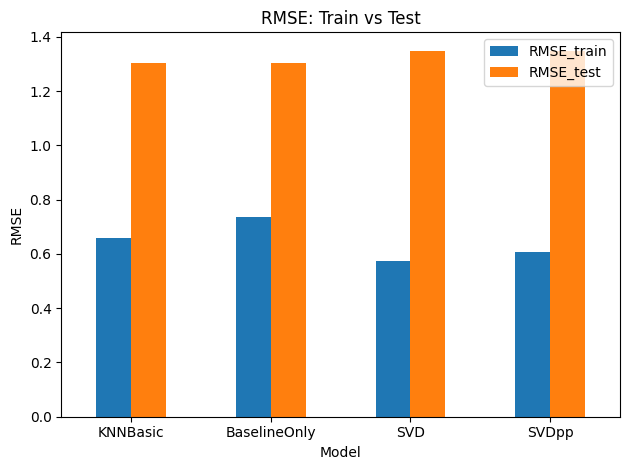

In [98]:
ax = results_df.plot(
    x="Model",
    y=["RMSE_train", "RMSE_test"],
    kind="bar",
    rot=0,
    title="RMSE: Train vs Test",
)
ax.set_ylabel("RMSE")
plt.tight_layout()
plt.show()



In [99]:


# Build Surprise dataset from MovieLens ratings_df
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['UserID', 'MovieID', 'Rating']], reader)

models = {
    'BaselineOnly': BaselineOnly(verbose=False),
    'KNNBasic': KNNBasic(sim_options={'name': 'pearson_baseline', 'user_based': True}, verbose=False),
    'SVD': SVD(random_state=42, verbose=False),
    'SVDpp': SVDpp(random_state=42, verbose=False),
}

rows = []
for name, algo in models.items():
    cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)
    rows.append({'Model': name, 'RMSE_5F': float(np.mean(cv_results['test_rmse']))})

metrics_df = pd.DataFrame(rows)



In [100]:
metrics_df

,Model,RMSE_5F
0,BaselineOnly,0.944092
1,KNNBasic,0.999223
2,SVD,0.937001
3,SVDpp,0.921824


In [101]:
results_df = results_df.merge(metrics_df, on="Model", how="left")
results_df

,Model,RMSE_train,MAE_train,RMSE_test,MAE_test,RMSE_5F
0,KNNBasic,0.659917,0.516062,1.301997,1.030518,0.999223
1,BaselineOnly,0.735899,0.587156,1.302254,1.031548,0.944092
2,SVD,0.573929,0.451405,1.346382,1.067283,0.937001
3,SVDpp,0.608654,0.477531,1.348845,1.070403,0.921824


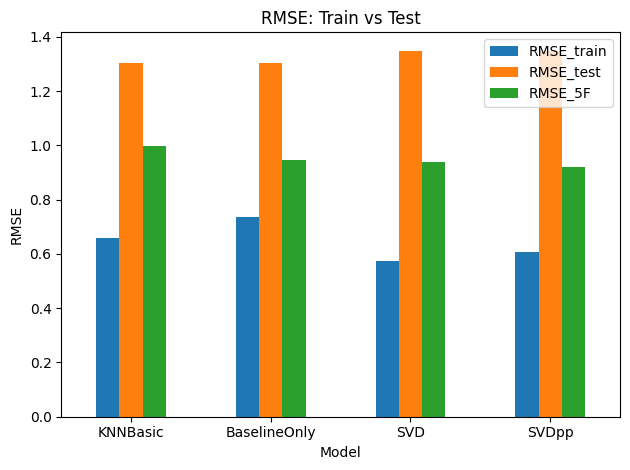

In [102]:
ax = results_df.plot(
    x="Model",
    y=["RMSE_train", "RMSE_test","RMSE_5F"],
    kind="bar",
    rot=0,
    title="RMSE: Train vs Test",
)
ax.set_ylabel("RMSE")
plt.tight_layout()
plt.show()

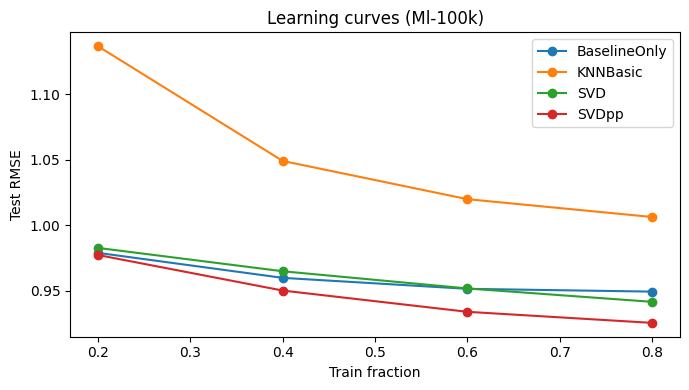

In [103]:

def get_models():
    return {
        "BaselineOnly": BaselineOnly(verbose=False),
        "KNNBasic": KNNBasic(
            sim_options={"name": "pearson_baseline", "user_based": True},
            verbose=False,
        ),
        "SVD": SVD(random_state=42, verbose=False),
        "SVDpp": SVDpp(random_state=42, verbose=False),
    }


def eval_models(df, train_frac=0.8, seed=42):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[["UserID", "MovieID", "Rating"]], reader)
    trainset, testset = train_test_split(
        data, test_size=(1 - train_frac), random_state=seed
    )

    rows = []
    for name, algo in get_models().items():
        algo.fit(trainset)
        preds = algo.test(testset)
        rmse = accuracy.rmse(preds, verbose=False)
        rows.append({"Model": name, "RMSE": float(rmse)})

    return pd.DataFrame(rows)



fractions = [0.2, 0.4, 0.6, 0.8]
seeds = [0, 1, 2]

curve_rows = []
for frac in fractions:
    for s in seeds:
        res = eval_models(ratings_df, train_frac=frac, seed=s)
        res["TrainFrac"] = frac
        curve_rows.append(res)

curve_df = pd.concat(curve_rows, ignore_index=True)
curve_mean = (
    curve_df.groupby(["Model", "TrainFrac"], as_index=False)["RMSE"]
    .mean()
)

plt.figure(figsize=(7, 4))
for model in curve_mean["Model"].unique():
    subset = curve_mean[curve_mean["Model"] == model]
    plt.plot(subset["TrainFrac"], subset["RMSE"], marker="o", label=model)
plt.title("Learning curves (Ml-100k)")
plt.xlabel("Train fraction")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


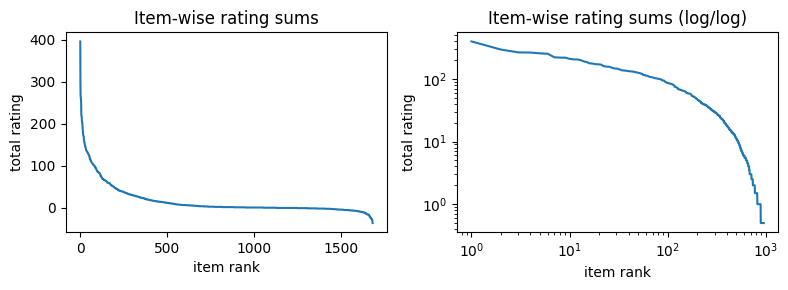

In [104]:


# Rescale ratings from [1, 5] to [-1, 1]
df = ratings_df.copy()
df["Rating"] = (df["Rating"] - 3.0) / 2.0

item_sums = df.groupby("MovieID")["Rating"].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.arange(1, len(item_sums) + 1), item_sums.values)
axes[0].set_title("Item-wise rating sums")
axes[0].set_xlabel("item rank")
axes[0].set_ylabel("total rating")

# Log-log plot: keep only positive sums
item_pos = item_sums[item_sums > 0]
axes[1].plot(np.arange(1, len(item_pos) + 1), item_pos.values)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Item-wise rating sums (log/log)")
axes[1].set_xlabel("item rank")
axes[1].set_ylabel("total rating")

plt.tight_layout()
plt.show()


In [111]:
def make_synthetic(alpha_user=0.9, alpha_item=0.9, seed=42, density=0.063):
    U, I = 943, 1682
    pairs, uc, ic, A = generate_mask_zipf_global(
        U,
        I,
        density=density,
        alpha_user=alpha_user,
        alpha_item=alpha_item,
        seed=seed,
        min_user_ratings=20,
        min_item_ratings=5,
        n_user_clusters=12,
        n_item_clusters=18,
        beta=1,
        return_clusters=True,
    )

    R_syn = fill_ratings_clusters(
        U=U,
        I=I,
        pairs=pairs,
        user_cluster=uc,
        item_cluster=ic,
        tau=np.array([-1.2, -0.4, 0.4, 1.2]),
        seed=seed,
        mu=0.4,
        sigma_bu=0.5,
        sigma_bi=0.5,
        sigma_eps=0.45,
        gamma=0.5,
        A=A,
    )

    ratings_long = pd.DataFrame(R_syn).stack().reset_index()
    ratings_long.columns = ["UserID", "MovieID", "Rating"]
    return ratings_long


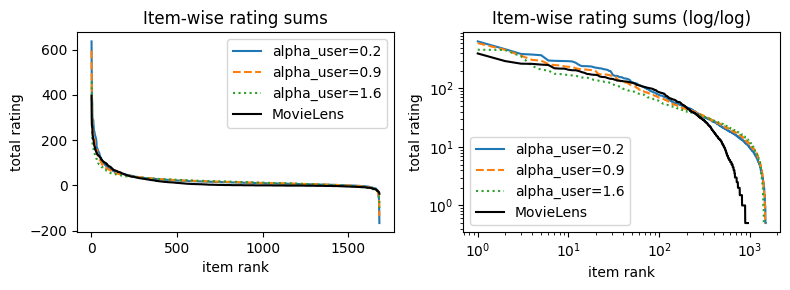

In [ ]:
# Compare item popularity shape across alpha_user values (plus real data)
alpha_users = [0.2, 0.9, 1.6]
styles = ["-", "--", ":"]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for a, ls in zip(alpha_users, styles):
    df = make_synthetic(alpha_user=a, seed=42)
    df = df.copy()
    df["Rating"] = (df["Rating"] - 3.0) / 2.0

    item_sums = df.groupby("MovieID")["Rating"].sum().sort_values(ascending=False)
    axes[0].plot(np.arange(1, len(item_sums) + 1), item_sums.values, linestyle=ls, label=f"alpha_user={a}")

    item_pos = item_sums[item_sums > 0]
    axes[1].plot(np.arange(1, len(item_pos) + 1), item_pos.values, linestyle=ls, label=f"alpha_user={a}")

# Add real data (MovieLens)
df_real = ratings_df.copy()
df_real["Rating"] = (df_real["Rating"] - 3.0) / 2.0
item_sums_real = df_real.groupby("MovieID")["Rating"].sum().sort_values(ascending=False)
axes[0].plot(np.arange(1, len(item_sums_real) + 1), item_sums_real.values, color="black", label="MovieLens")
item_pos_real = item_sums_real[item_sums_real > 0]
axes[1].plot(np.arange(1, len(item_pos_real) + 1), item_pos_real.values, color="black", label="MovieLens")

axes[0].set_title("Item-wise rating sums")
axes[0].set_xlabel("item rank")
axes[0].set_ylabel("total rating")
axes[0].legend()

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Item-wise rating sums (log/log)")
axes[1].set_xlabel("item rank")
axes[1].set_ylabel("total rating")
axes[1].legend()

plt.tight_layout()
plt.show()


## User-wise sums and singular value spectrum (synthetic vs MovieLens)


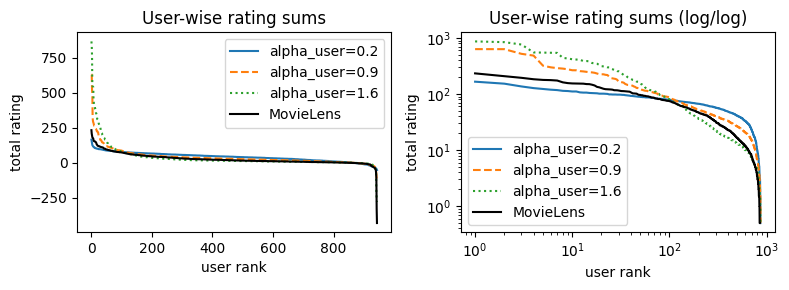

In [114]:
# Compare user activity shape across alpha_user values (plus real data)
alpha_users = [0.2, 0.9, 1.6]
styles = ["-", "--", ":"]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for a, ls in zip(alpha_users, styles):
    df = make_synthetic(alpha_user=a, seed=42)
    df = df.copy()
    df["Rating"] = (df["Rating"] - 3.0) / 2.0

    user_sums = df.groupby("UserID")["Rating"].sum().sort_values(ascending=False)
    axes[0].plot(np.arange(1, len(user_sums) + 1), user_sums.values, linestyle=ls, label=f"alpha_user={a}")

    user_pos = user_sums[user_sums > 0]
    axes[1].plot(np.arange(1, len(user_pos) + 1), user_pos.values, linestyle=ls, label=f"alpha_user={a}")

# Add real data (MovieLens)
df_real = ratings_df.copy()
df_real["Rating"] = (df_real["Rating"] - 3.0) / 2.0
user_sums_real = df_real.groupby("UserID")["Rating"].sum().sort_values(ascending=False)
axes[0].plot(np.arange(1, len(user_sums_real) + 1), user_sums_real.values, color="black", label="MovieLens")
user_pos_real = user_sums_real[user_sums_real > 0]
axes[1].plot(np.arange(1, len(user_pos_real) + 1), user_pos_real.values, color="black", label="MovieLens")

axes[0].set_title("User-wise rating sums")
axes[0].set_xlabel("user rank")
axes[0].set_ylabel("total rating")
axes[0].legend()

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("User-wise rating sums (log/log)")
axes[1].set_xlabel("user rank")
axes[1].set_ylabel("total rating")
axes[1].legend()

plt.tight_layout()
plt.show()


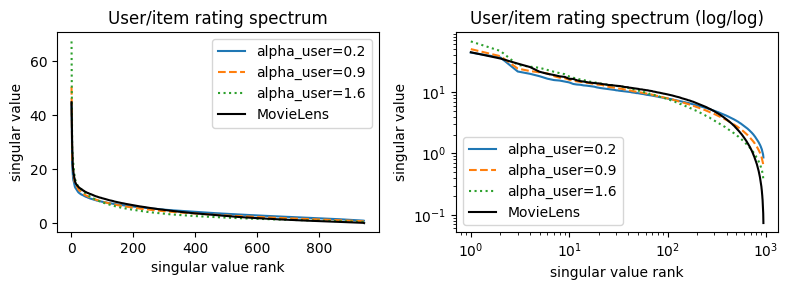

In [110]:

def center_matrix_from_df(df, U, I):
    mat = np.zeros((U, I), dtype=np.float32)
    mean_rating = df["Rating"].mean()
    u = df["UserID"].to_numpy()
    i = df["MovieID"].to_numpy()
    r = df["Rating"].to_numpy()
    mat[u, i] = r - mean_rating
    return mat

# Singular value spectrum (synthetic alpha_user + MovieLens)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for a, ls in zip(alpha_users, styles):
    df = make_synthetic(alpha_user=a, seed=42)
    df = df.copy()
    df["Rating"] = (df["Rating"] - 3.0) / 2.0

    U = int(df["UserID"].max()) + 1
    I = int(df["MovieID"].max()) + 1
    mat = center_matrix_from_df(df, U, I)
    s = np.linalg.svd(mat, full_matrices=False, compute_uv=False)

    axes[0].plot(np.arange(1, len(s) + 1), s, linestyle=ls, label=f"alpha_user={a}")

    s_pos = s[s > 0]
    axes[1].plot(np.arange(1, len(s_pos) + 1), s_pos, linestyle=ls, label=f"alpha_user={a}")

U_real = int(df_real["UserID"].max()) + 1
I_real = int(df_real["MovieID"].max()) + 1
mat_real = center_matrix_from_df(df_real, U_real, I_real)
s_real = np.linalg.svd(mat_real, full_matrices=False, compute_uv=False)
axes[0].plot(np.arange(1, len(s_real) + 1), s_real, color="black", label="MovieLens")
s_real_pos = s_real[s_real > 0]
axes[1].plot(np.arange(1, len(s_real_pos) + 1), s_real_pos, color="black", label="MovieLens")

axes[0].set_title("User/item rating spectrum")
axes[0].set_xlabel("singular value rank")
axes[0].set_ylabel("singular value")
axes[0].legend()

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("User/item rating spectrum (log/log)")
axes[1].set_xlabel("singular value rank")
axes[1].set_ylabel("singular value")
axes[1].legend()

plt.tight_layout()
plt.show()
